# Pruned Monte-Carlo

* Cでシュミレーションだけやってしまう

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import random
import time
from collections import deque
from InfMaxProblem import Monte_Carlo as mc

%matplotlib inline

In [2]:
# データの読み込み
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.111111
1,0,5,0.090909
2,0,7,0.333333
3,0,8,0.250000
4,0,9,0.333333


In [3]:
# numpy型に変換
network_np = network.values

In [4]:
# 入力は隣接リスト(numpy)[[from_node, to_node, edge_prob],...]
def live_edge_graph_edges(p, p_len):
    rand = np.random.uniform(0, 1, p_len)
    return np.array([[p[i][0], p[i][1]] for i in range(p_len) if rand[i] < p[i][2]])

In [5]:
# 幅優先探索によって、Sから到達可能なノードを返す
def bfs(G, S):
    visited = {s:None for s in S}
    queue = deque(S)
    while queue:
        v = queue.popleft()
        out_node = G.successors(v)
        for u in out_node:
            if not (u in visited):
                queue.append(u)
                visited[u] = v
    return visited

In [6]:
# 幅優先探索によって、Sから到達可能なノードを返す
def bfs_reverse(G, S):
    visited = {s:None for s in S}
    queue = deque(S)
    while queue:
        v = queue.popleft()
        in_node = G.predecessors(v)
        for u in in_node:
            if not (u in visited):
                queue.append(u)
                visited[u] = v
    return visited

In [7]:
# 強連結成分分解に使うための関数
def dfs_go(G):
    visited = dict([])
    # vs:帰りがけ順
    vs = deque([])
    for s in G.node():
        if s not in visited:
            visited[s] = None
            Stack = deque([s])
            vs_tmp = deque([s])
            while Stack:
                v = Stack.pop()
                #if v not in vs_tmp:
                vs_tmp.appendleft(v)
                out_node = G[v]
                for u in out_node:
                    if u not in visited:
                        visited[u] = s
                        Stack.append(u)
            #vs = vs_tmp + vs
            vs.extendleft(vs_tmp)
    return visited, vs

# 強連結成分分解に使うための関数
def dfs_back(G, vs):
    group = dict([])
    group_num = 0
    DAG = nx.DiGraph()
    for s in vs:
        if s not in group:
            w = 1
            Stack = deque([s])
            members = []
            while Stack:
                v = Stack.pop()
                members.append(v)
                group[v] = group_num
                in_node = G.predecessors(v)
                for u in in_node:
                    if u not in group:
                        group[u] = group_num
                        w += 1
                        Stack.append(u)
                    else:
                        if group_num !=  group[u]:
                            DAG.add_edge(group[u], group_num)
            DAG.add_node(group_num, weight=w, members=members)
            group_num += 1
    return group, DAG

def scc_DAG(G):
    visited ,vs = dfs_go(G)
    group, DAG = dfs_back(G, vs)
    return group, DAG

In [8]:
%time simulation = live_edge_graph_edges(network_np, len(network_np))

CPU times: user 804 µs, sys: 710 µs, total: 1.51 ms
Wall time: 882 µs


In [9]:
len(simulation)

30

In [10]:
# i回目のシュミレーションでv_Vが到達できる頂点数
def GAIN(i, v_V, comp, G, A, S, h, D):
    # v:i回目のシュミレーションで作成されたグラフのv_Vを含む強連結成分
    v = comp[i][v_V]
    
    # V[i]にvがない場合0(後に消されていくため)
    if v not in G[i].nodes():
        delta[i][v] = 0
        return 0
    
    # ? delta
    if latest[i][v]:
        return delta[i][v]
        
    latest[i][v] = True
    
    # len(S)==0の理由は初回のみ行えば良いため(h(ハブ)以降の到達頂点数は一回行えば十分であるため)
    # vがhのacestorだった場合、hの到達頂点数を計算して、他のacestorの時にも使い回す
    if (v in A[i]) and (len(S) == 0):
        # GAINの引数は後で変える
        # hのGAINをはじめから足しておく
        h_Vs = G[i].nodes[h[i]]["members"]
        for h_V in h_Vs:
            delta[i][v] = GAIN(i, h_V, comp, G, A, S, h, D)
    else:
        delta[i][v] = 0
    
    # bfs
    Q = deque([v])
    # Xは探索済みの強連結成分
    X = set([v])
    while Q:
        u = Q.popleft()
        
        # 意味不明
        #if (v in A[i]) and (u in D[i]) and (len(S) == 0):
            #continue
        delta[i][v] += G[i].nodes[u]["weight"]
        
        
        Edges = G[i].out_edges(u)
        for u_, w in Edges:
            # uから出ている任意の枝について探索する
            if u_ == u:
                # 探索済みの強連結成分は探索しなくていいので、w not in X
                # w in V[i]はのちのupdateでV[i]が変化するため
                if (w not in X) and (w in G[i].nodes()):
                    Q.append(w)
                    X.add(w)
        
    return delta[i][v]

In [11]:
def UPDATEDAG(i, t_V, comp, G):
    # t:DAG上でのノードid
    t = comp[i][t_V]
    
    if t in G[i]:
        # t -> u
        u = list(bfs(G[i], [t]))
        # v -> u:上で求めたuにだどりつくvを求める
        v = list(bfs_reverse(G[i], u))

        # 上の２条件を満たす集合がv
        v = set(u) & set(v)

        # v かつ Viに存在する頂点
        v_ = list(v & set(G[i].nodes()))
        latest[i].update(zip(v_, [False]*len(v_)))

        G[i].remove_nodes_from(u)
        return G[i]
    else:
        return G[i]

In [12]:
def PMC_greedy(network_np, k, R):
    E_ = dict([])
    G_ = dict([])
    G = dict([])
    comp = dict([])
    h = dict([])
    D = dict([])
    A = dict([])
    V = dict([])
    global latest
    latest = dict([])
    global delta
    delta = {i:dict([]) for i in range(R)}
    
    # 全体のグラフ
    G_all = nx.DiGraph()
    G_all.add_weighted_edges_from(network_np)
    
    # 元グラフの頂点集合
    G_V = [int(node) for node in G_all.node()]
    
    # copy用に作っておく
    G_copy = nx.DiGraph()
    G_copy.add_nodes_from(G_V)
    
    for i in tqdm(range(R)):
        
        start = time.time()
        # 各辺 e を確率 pe で残すことで得られる辺集合
        E_[i] = live_edge_graph_edges(network_np, len(network_np))
        
        start = time.time()
        G_[i] = G_copy.copy()
        G_[i].add_edges_from(E_[i])
        
        start = time.time()
        # G_i_ = (V, E_i_) の強連結成分を計算
        # G_i_より構築された頂点重み付き DAG
        # comp[元ノード]→DAGノード
        # G[i]:DAG
        # V[i]:{DAGノード:weight}
        # E[i]:DAG枝(作成段階で重複があるためsetをしている)
        comp[i], G[i] = scc_DAG(G_[i])
        
        # h_i ← V_i において最大の次数をもつ頂点
        G_i_deg = dict(G[i].degree())
        h[i] = max(G_i_deg, key=G_i_deg.get)
        
        # h_iから到達可能な頂点集合
        # ? 型は未定
        # D:Descendant
        D[i] = set(bfs(G[i], [h[i]]))
        
        # h_iに到達可能な頂点集合
        # ? 型は未定
        # A:Ancestor
        A[i] = set(bfs_reverse(G[i], [h[i]])) - set([h[i]])
        
        V[i] = G[i].node()
        latest[i] = {v:False for v in V[i]}
    print("comp init")
    
    S = []
    for j in range(k):
        v_gain = {v:sum([GAIN(i, v, comp, G, A, S, h, D) for i in range(R)])/R for v in tqdm(G_V)}
        t = max(v_gain, key=v_gain.get)
        
        S.append(t)
        
        for i in tqdm(range(R)):
            G[i] = UPDATEDAG(i, t, comp, G)
        
    return S

In [13]:
k = 5
R = 200
%time PMC_greedy(network_np, k, R)

# CPU times: user 16min, sys: 9min 10s, total: 25min 10s
# Wall time: 32min 56s
# [763, 645, 634, 71399, 3924]


comp init



CPU times: user 1.25 s, sys: 85.2 ms, total: 1.34 s
Wall time: 1.72 s


[0, 29, 25, 5, 11]

In [14]:
G = nx.DiGraph()
G.add_weighted_edges_from(network_np)

In [15]:
%time mc.approx_inf_size_IC_T(G, [0, 1, 29, 27, 26], 10000)

CPU times: user 6.73 s, sys: 39.5 ms, total: 6.77 s
Wall time: 7.15 s


20.2173

# 計算実験

In [16]:
def PMC_greedy_time(network_np, k, R):
    time_list = []
    # E_ = dict([])
    # G_ = dict([])
    G = dict([])
    comp = dict([])
    h = dict([])
    D = dict([])
    A = dict([])
    V = dict([])
    global latest
    latest = dict([])
    global delta
    delta = {i:dict([]) for i in range(R)}
    
    # 全体のグラフ
    G_all = nx.DiGraph()
    G_all.add_weighted_edges_from(network_np)
    
    # 元グラフの頂点集合
    G_V = [int(node) for node in G_all.node()]
    
    # copy用に作っておく
    G_copy = nx.DiGraph()
    G_copy.add_nodes_from(G_V)
    
    for i in tqdm(range(R)):
        
        E_ = live_edge_graph_edges(network_np, len(network_np))
        
        G_ = G_copy.copy()
        G_.add_edges_from(E_)
        
        comp[i], G[i] = scc_DAG(G_)
        
        G_i_deg = dict(G[i].degree())
        h[i] = max(G_i_deg, key=G_i_deg.get)
        
        D[i] = set(bfs(G[i], [h[i]]))
        
        A[i] = set(bfs_reverse(G[i], [h[i]])) - set([h[i]])
        
        V[i] = G[i].node()
        latest[i] = {v:False for v in V[i]}
    print("comp init")
    
    S = []
    for j in range(k):
        start = time.time()
        v_gain = {v:sum([GAIN(i, v, comp, G, A, S, h, D) for i in range(R)])/R for v in tqdm(G_V)}
        t = max(v_gain, key=v_gain.get)
        
        S.append(t)
        
        for i in range(R):
            G[i] = UPDATEDAG(i, t, comp, G)
            
        time_list.append(time.time())
        
    return S, time_list

## Epinions

In [17]:
run_time = dict([])
S = dict([])

### WC

In [18]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [19]:
# numpy型に変換
network_np = network.values

In [ ]:
start = time.time()
S["WC"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["WC"] = time.time() - start

In [ ]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time.to_csv("WC_df_seed_time.csv")

In [ ]:
WC_df_seed_time.plot()

In [ ]:
run_time["WC"]
# 14174.768389940262

In [ ]:
S["WC"]

# [763,
#  634,
#  645,
#  5232,
#  71399,
#  3924,
#  637,
#  145,
#  2969,
#  1172,
#  2066,
#  1835,
#  1596,
#  1225,
#  1059,
#  661,
#  546,
#  4931,
#  824,
#  5227,
#  44,
#  1720,
#  5144,
#  9412,
#  2704,
#  2118,
#  1409,
#  629,
#  3850,
#  1533,
#  6003,
#  5224,
#  590,
#  1669,
#  1539,
#  71388,
#  770,
#  7047,
#  1638,
#  3065,
#  4017,
#  646,
#  751,
#  4920,
#  1501,
#  7427,
#  1849,
#  2063,
#  6489,
#  7392]

### TR

In [15]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/TR.csv")
network.head()

,# FromNodeId,ToNodeId,TR
0,0,4,0.10
1,0,5,0.01
2,0,7,0.10
3,0,8,0.01
4,0,9,0.10


In [16]:
# numpy型に変換
network_np = network.values

In [17]:
start = time.time()
S["TR"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["TR"] = time.time() - start


comp init


In [18]:
TR_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
TR_df_seed_time

,Running Time[s]
Size of Seed Set,
1,1.578059e+09
2,1.578059e+09
3,1.578059e+09
4,1.578059e+09
5,1.578059e+09
6,1.578059e+09
7,1.578059e+09
8,1.578059e+09
9,1.578060e+09


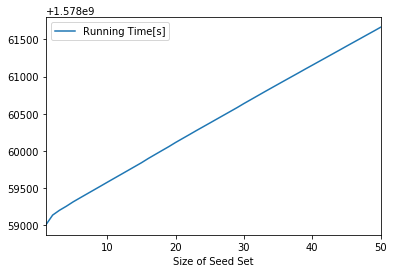

In [19]:
TR_df_seed_time.plot()

In [20]:
run_time["TR"]

29903.058850049973

In [21]:
S["TR"]

[5175,
 3805,
 12948,
 4077,
 622,
 1209,
 183,
 962,
 7430,
 260,
 2274,
 5803,
 8975,
 4154,
 4193,
 1643,
 1864,
 7642,
 5432,
 292,
 602,
 821,
 19583,
 10997,
 3515,
 591,
 1805,
 3519,
 1876,
 4784,
 3023,
 262,
 10070,
 17798,
 10845,
 5832,
 6963,
 188,
 4092,
 5752,
 3579,
 178,
 9419,
 6701,
 3488,
 3778,
 3926,
 1084,
 228,
 3816]

### P=0.1

In [13]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_1.csv")
network.head()

,# FromNodeId,ToNodeId,P=0.1
0,0,4,0.1
1,0,5,0.1
2,0,7,0.1
3,0,8,0.1
4,0,9,0.1


In [14]:
# numpy型に変換
network_np = network.values

In [ ]:
start = time.time()
S["P=0_1"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["P=0_1"] = time.time() - start


comp init


In [ ]:
P01_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P01_df_seed_time

In [ ]:
P01_df_seed_time.plot()

In [ ]:
run_time["P=0_1"]

In [ ]:
S["P=0_1"]